In [1]:
import numpy as np
import pandas as pd
import joblib
import rasterio
from rasterio.crs import CRS
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

model_path = "../../models/brtmodel.joblib.pkl"
brt = joblib.load(model_path)
image = rasterio.open(fr'C:\Users\admin\OneDrive\Computing\Yr5 Advanced Computing\MAC Project\Carbon-Trading-Verification\scotland_carbon\data\S1A_S2AL2A_INDICES_DEM_EVAL.tif')

num_bands = image.count
img_width = image.width
img_height = image.height
num_pixels = img_height * img_width
all_data = []
print("Image shape:", image.shape)



Image shape: (132, 194)


In [2]:
print("Converting Raster to Array...")
for i in tqdm(range(num_bands)):
    data = image.read(i+1)
    data = pd.DataFrame(data).fillna(0).to_numpy()
    all_data.append(data)

all_data = np.dstack(all_data)
all_data_shape = all_data.shape
print("Raster array shape:", all_data_shape)




100%|███████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 439.06it/s]

Converting Raster to Array...
Raster array shape: (132, 194, 18)


In [3]:
print("Calculating SOC...")
result_data = []
non_zero = 0
for t in tqdm(all_data):
    z = brt.predict(t)
    result_data.append(z)
    non_zero += np.count_nonzero(z)
    z[z!=z] = 0
    # print(torch.min(z), torch.max(z))
print("non_zero:", non_zero)

# result_data = np.exp(np.stack(result_data))
result_data = np.stack(result_data)

# Transform result_data for display
print(result_data)
result_data = np.exp(result_data)

# x_pos, x_label = 
# y_pos, y_label = 



# with rasterio.open(
#     '../../out/brt_map.tif',
#     'w',
#     driver='GTiff',
#     height=result_data.shape[0],
#     width=result_data.shape[1],
#     count=1,
#     dtype=result_data.dtype,
#     crs=CRS.from_epsg(27700),
#     transform=image.transform,
# ) as dst:
#     dst.write(result_data, 1)

  0%|                                                                            | 0/132 [00:00<?, ?it/s]

Calculating SOC...


100%|█████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 148.16it/s]

non_zero: 25608
[[ 6.60629338  6.60991854  6.530939   ...  6.55171533  6.42598535
   5.09594896]
 [ 6.41667985  6.49457805  6.17629887 ...  6.46858083  6.48209042
   5.32130366]
 [ 6.55849379  6.55449671  6.45427586 ...  6.08744015  6.43984007
   4.99040051]
 ...
 [ 7.21163599  7.06741596  7.12321749 ...  6.21852887  6.2465192
   4.948062  ]
 [ 7.39103931  7.24109573  7.44465903 ...  4.80050141  6.20917453
   5.02067153]
 [ 2.72989645  2.68542773  2.60463656 ...  1.06137455  0.47175958
  -0.45264247]]


In [6]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

def plot_graph(result_data, file_name):
    fontprops = fm.FontProperties(size=12)
    # https://epsg.io/transform#s_srs=27700&t_srs=4326&x=293167.0000000&y=652518.0000000
    # topleft - x = -3°42.2263', y = 55°45.25162'
    # x = -3.7037717°, y = 55.7541937°
    # bottomright - x = -2.7696528°, y = 55.4075244°
    x_coord_l, x_coord_r = -3.7037717, -2.7696528
    y_coord_t, y_coord_b = 55.7541937, 55.4075244
    x_shape = result_data.shape[1]
    y_shape = result_data.shape[0]

    def x_format_func(value, tick_number):
        out = (x_coord_l + (value / x_shape * (x_coord_r - x_coord_l)))
        return "{v:.2f}\N{DEGREE SIGN}".format(v=out)

    def y_format_func(value, tick_number):
        out = (y_coord_t - (value / y_shape * (y_coord_t - y_coord_b)))
        return "{v:.2f}\N{DEGREE SIGN}".format(v=out)

    ax = plt.axes()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(x_format_func))
    # ax.xaxis.set_major_locator(plt.MaxNLocator(7))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(y_format_func))
    # ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    scalebar = AnchoredSizeBar(ax.transData,
                               33.3, '10 km', 'lower right', 
                               pad=0.1,
                               color='black',
                               frameon=False,
                               size_vertical=1,
                               fontproperties=fontprops)

    ax.add_artist(scalebar)


    plt.xlabel("Latitude")
    plt.ylabel("Londgitude")
    plt.imshow(result_data, cmap='Greens')
#     plt.colorbar(label="Amount of Soil Organic Carbon (Mg C/ha)")
#     plt.savefig(file_name)
    plt.show()

(131, 193)


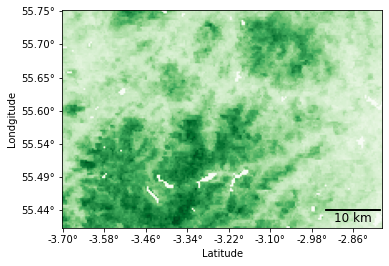

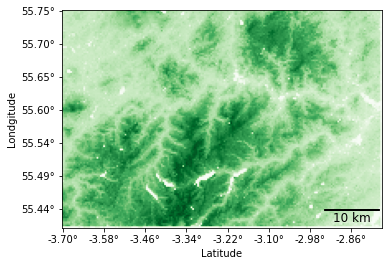

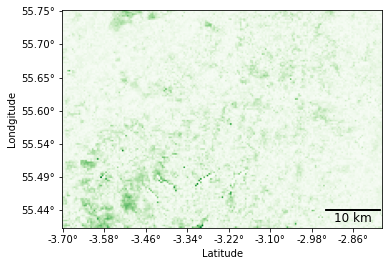

In [7]:
image = rasterio.open(fr'C:\Users\admin\OneDrive\Computing\Yr5 Advanced Computing\MAC Project\Carbon-Trading-Verification\scotland_carbon\data\Train_SG_15-30_27700_clipped.tif')
data = image.read(1)
print(data.shape)
plot_graph(data, '../../report_output/experiment1/brt_truth.png')
plot_graph(result_data, '../../report_output/experiment1/brt_pred.png')
plot_graph(np.abs(data-result_data[:131, :193]), '../../report_output/experiment1/brt_err.png')